This notebook implements three Gibbs sampling algorithms for MNIST clustering with missing data (pixels)  
1) Uncollapsed Gibbs where we sample missing pixels in each iteration to produce an augmented dataset for sampling Bernoulli biases and latent cluster assignments
2) Uncollapsed Gibbs where we ignore missing pixels in each iteration, using only observed pixels for sampling Bernoulli biases and latent cluster assignments, effectively marginalizing out missing pixels
3) Collapsed Gibbs where we sample missing pixels in each iteration to produce an augmented dataset for sampling latent cluster assignments

In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse
import random

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

In [4]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

In [5]:
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

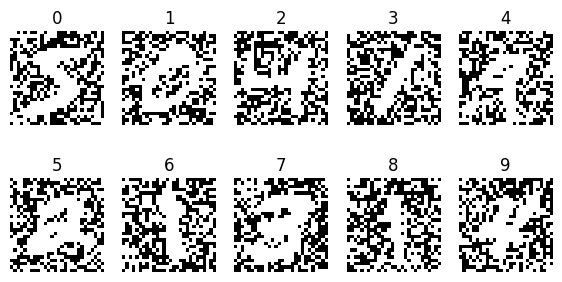

In [6]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = X_mnist_cover1[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## Likelihood Functions

In [7]:
def bernoulli_loglike(X, θ, π):
    # Compute Categorical Distribution over components for each row using SoftMax
    logp  = np.log(π) + (X @ np.log(θ).T + (1 - X) @ np.log(1 - θ).T) # log likelihood
    logp -= logp.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(logp)
    p    /= p.sum(axis=1, keepdims=True) # normalize

    return p

In [8]:
def bernoulli_loglike_missing(X, θ, π, missing_mask):
    N,D = X.shape
    K,_ = θ.shape 
    log_ps = np.zeros((N,K))

    for i in range(N):
        for k in range(K):
            mask = np.where(~missing_mask[i])[0]

            log_ps[i,k] = np.log(π[k]) + np.sum((X[i] * np.log(θ[k]))[mask]) + np.sum(((1 - X[i]) * np.log(1 - θ[k]))[mask])

    log_ps -= log_ps.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(log_ps)
    p    /= p.sum(axis=1, keepdims=True) # normalize  

    return p


# 1 Un-Collapsed Gibbs Sampling (Sampling Missing Pixels)

1) Initialize 

    * $\boldsymbol{\alpha} = [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]$
    * $a,b = \frac{1}{2}$
    * $\boldsymbol{\pi} \sim \mathbf{Dirichlet}(\boldsymbol{\alpha})$
    * $\boldsymbol{\theta} \sim \mathbf{Beta}(\mathbf{a,b})$
    * For $i\in{1,...,N}$
        * $z_i \sim \mathbf{Categorical}(\boldsymbol{\pi})$
    * For $i\in{1,...,N}$
        * $\mathbf{x}_{i,H} \sim \mathbf{Bernoulli}(\theta_{z_i})$

2) For $t = 1,\dots,N$

$$
\begin{align}
  \text{Sample } \boldsymbol{\pi}^{(t)}
    &\sim P(\boldsymbol{\pi}\mid\boldsymbol{z}^{(t-1)})
      = \mathrm{Dirichlet}\bigl(\boldsymbol{\alpha}_N^{(t-1)}\bigr) \\
  \boldsymbol{\alpha}_N^{(t-1)}
    &= \bigl[\alpha_0^1+n_1,\;\alpha_0^2+n_2,\;\dots,\;\alpha_0^K+n_K\bigr],
       \; n_k^{(t-1)}=\sum_{i=1}^N\mathbf 1(z_i^{(t-1)}=k) \\\\[6pt]


  \text{Sample } \boldsymbol{\pi}^{(t)} &\sim P(\boldsymbol{\pi} | \boldsymbol{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}) \\
        \boldsymbol{\alpha}_N^{(t-1)} &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample }\mathbf X^{(t)}
        &\sim P(\mathbf X\mid\mathbf z^{(t-1)},\boldsymbol{\theta}^{(t-1)}) \\
    \text{for } i &\in \{1,\dots,N\}: \;
        \mathbf x_{H,i}^{(t)}\sim\mathrm{Bernoulli}\bigl(\theta^{(t-1)}_{z_i^{(t-1)}}\bigr)\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim P(\boldsymbol{\theta}|\mathbf{X}^{(t)},\mathbf{z}^{(t-1)}) = \prod_k^K \prod_d^D \mathrm{Beta}(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)}), \quad \text{where}\\
        &n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 1, z_i^{(t-1)} = k)\\
        &n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 0, z_i^{(t-1)} = k)\\\\


  \text{Sample }\mathbf z^{(t)}
    &\sim P(\mathbf z\mid\mathbf X^{(t)},\boldsymbol{\pi}^{(t)},\boldsymbol{\theta}^{(t)}) \\
  \text{for } i &\in \{1,\dots,N\}: \;
    z_i^{(t)}\sim\text{Categorical}(p_1^{(i)},\dots,p_K^{(i)}), \\[2pt]
    &\qquad
    p_k^{(i)}\propto \pi_k^{(t)}
      \prod_{d=1}^D
      (\theta_{k,d}^{(t)})^{x_{i,d}^{(t)}}
      (1-\theta_{k,d}^{(t)})^{1-x_{i,d}^{(t)}} \\\\[6pt]
\end{align}
$$

3) Discard burn-in samples


In [9]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs.astype(np.int64), minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [10]:
def sampleZs(p):
    ''' 
        Samples cluster assignments z for n datapoints 

        @param (p) : softmax categorical probabilities over clusters (N, K)
    '''

    # Inverse sample from categorical distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [11]:
def sample_X_missing(z, θ, X, missing_mask):
    n, D = X.shape
    X_sample = X.copy()

    θ_indexed = θ[z]  # shape (n, D)

    sampled = np.random.binomial(1, θ_indexed)

    X_sample[missing_mask] = sampled[missing_mask]

    return X_sample

In [12]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]

    nk = np.sum(zs_zerohot, axis=0)
    nkd1 = zs_zerohot.T @ X
    nkd0 = nk[:, None]- nkd1
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [14]:
def gibbs_missing(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape

    missing_mask = np.isnan(X) # (n,d)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))
    Xs = np.zeros((num_iter + num_burn, n, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = np.random.randint(0,K,size=n)
    Xs[0] = sample_X_missing(zs[0],θs[0],X,missing_mask)

    for t in range(1,num_iter+num_burn):
        πs[t] = sample_π(zs[t-1], α_0, 10)

        θs[t] = sample_θ(Xs[t-1], zs[t-1], a_mat, b_mat, K)
        
        zs[t] = sampleZs(bernoulli_loglike(X, θs[t],πs[t])).astype(np.int16)

        Xs[t] = sample_X_missing(zs[t],θs[t],X,missing_mask)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:], Xs[num_burn:]

In [16]:
πs,θs,zs,xs= gibbs_missing(X_mnist_cover1, 400, 4, 10)

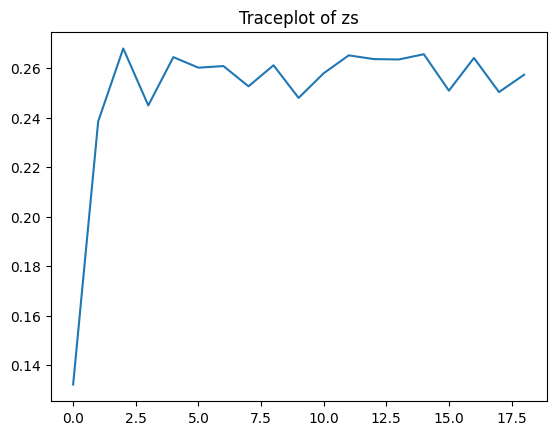

In [22]:
scores = [metrics.adjusted_rand_score(Y_mnist_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

# 2 Un-Collapsed Gibbs Sampling (Marginalizing missing pixels)

Joint Posterior 

$$\begin{align}
    p(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\boldsymbol{\alpha},a,b) \propto p(\mathbf{X}|\mathbf{z},\boldsymbol{\theta}) p(\mathbf{z}|\boldsymbol{\pi}) p(\boldsymbol{\pi}|\boldsymbol{\alpha}) p(\boldsymbol{\theta}|a,b)
\end{align}$$

Routine

1) Initialize 
$$\begin{align}
    \boldsymbol{\alpha} &= [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]\\
    a,b &= \frac{1}{2}\\
    \boldsymbol{\pi} &\sim \mathcal{Dirichlet}(\boldsymbol{\alpha}) \\
    \boldsymbol{\theta} &\sim \mathcal{Beta}(a,b)\\
    \boldsymbol{z} &\sim \mathcal{Cat}(\boldsymbol{\pi})
\end{align}$$



2) For $t=1,..,N$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim P(\boldsymbol{\pi} | \boldsymbol{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}) \\
        \boldsymbol{\alpha}_N^{(t-1)} &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample }\mathbf X^{(t)}
        &\sim P(\mathbf X\mid\mathbf z^{(t-1)},\boldsymbol{\theta}^{(t-1)}) \\
    \text{for } i &\in \{1,\dots,N\}: \;
        \mathbf x_{H,i}^{(t)}\sim\mathrm{Bernoulli}\bigl(\theta^{(t-1)}_{z_i^{(t-1)}}\bigr)\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim P(\boldsymbol{\theta}|\mathbf{X}^{(t)},\mathbf{z}^{(t-1)}) = \prod_k^K \prod_d^D \mathrm{Beta}(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)}), \quad \text{where}\\
        &n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 1, z_i^{(t-1)} = k)\\
        &n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 0, z_i^{(t-1)} = k)\\\\

    \text{Sample } \mathbf{z}^{(t)} \sim &P(\mathbf{z}|\mathbf{X}_O,\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)})\\

        \text{For } i &\in {1,..,N} \text{ and } d \in {\mathbf{X}_O}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} \prod_{d=1}^D (\theta_{k,d}^{(t)})^{x_{i,d}}(1-\theta_{k,d}^{(t)})^{(1 - x_{i,d})}\\\\

\end{align}$$

3. Discard burn-in samples

In [83]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]

    nk = np.sum(zs_zerohot, axis=0)
    nkd1 = zs_zerohot.T @ X
    nkd0 = nk[:, None]- nkd1
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [ ]:

def sample_θ(X, zs, a_mat, b_mat, K, missing_mask) :
    n,D=X.shape
    obs_mask = ~missing_mask

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]

    obs_k = zs_zerohot.T @ obs_mask

    nkd1 = zs_zerohot.T @ np.nan_to_num(X * obs_mask, nan=0)

    nkd0 = obs_k - nkd1

    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [20]:
def sample_X_missing(z, θ, X, missing_mask):
    n, D = X.shape
    X_sample = X.copy()

    θ_indexed = θ[z]  # shape (n, D)

    sampled = np.random.binomial(1, θ_indexed)

    X_sample[missing_mask] = sampled[missing_mask]

    return X_sample

In [29]:
def gibbs_missing(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape

    missing_mask = np.isnan(X) # (n,d)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = np.random.randint(0,K,size=n)

    for t in range(1,num_iter+num_burn):

        πs[t] = sample_π(zs[t-1], α_0, K)

        θs[t] = sample_θ(X, zs[t-1], a_mat, b_mat, K, missing_mask)
        
        zs[t] = sampleZs(bernoulli_loglike(X, θs[t],πs[t],missing_mask)).astype(np.int16)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:]

In [ ]:
πs,θs,zs= gibbs_missing(X_mnist_cover1, 400, 4, 10)

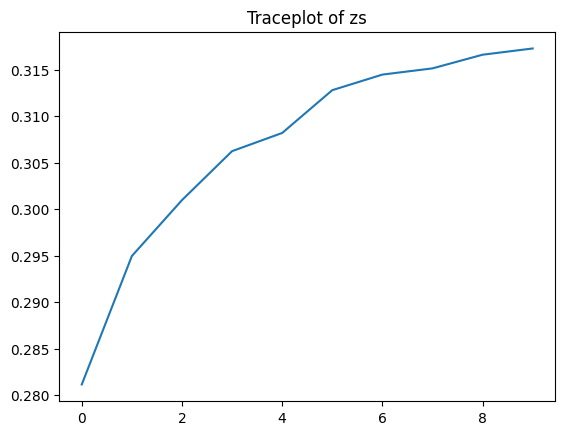

In [31]:
scores = [metrics.adjusted_rand_score(Y_mnist_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [32]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3172723784911137

# 3 Uncollapsed Gibbs With Missing Data

Goal is to integrate out $\theta$ and $\pi$ so we can directly just sample $z$ alone.

Full Posterior:
$$
    P(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\mathbf{a},\mathbf{b},\boldsymbol{\alpha})\propto \underbrace{p(\mathbf{X}|\mathbf{z},\mathbf{\theta}) p(\mathbf{\theta}|a,b)}_{\text{Conjugacy}} \underbrace{p(\mathbf{z}|\mathbf{\pi}) p(\mathbf{\pi}|\mathbf{\alpha})}_{\text{Conjugacy}}
$$

Goal

$$\begin{align}
    P(\mathbf{z}|\mathbf{X}) = \int\int P(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\mathbf{a},\mathbf{b},\boldsymbol{\alpha})d\mathbf{\theta}d\mathbf{\pi}
\end{align}$$

---

## Beta-Binomial Conjugacy:
$$\begin{align}
    \underset{Binomial}{P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})}&\underset{Beta}{P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})} &= 
        \left[ \prod_{i}^{N} \prod_{d}^{D} \theta_{d,z_i}^{x_{d,i}} (1 - \theta_{d,z_i})^{(1 - x_{d,i})} \right]\left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}(1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]
\end{align}$$

$\quad$ Let $n_{d,k}^{(1)} = \sum_{i}^{N} \mathbb{1}(z_i = k, x_{d,i} = 1)$,  hence $\quad \prod_{i}^{N} \theta_{d,z_i}^{x_{d,i}} = \prod_{k}^{K} \theta_{d,k}^{n_{d,k}^{(1)}}$

$$\begin{align}
     &= \left[ \prod_{k}^{K} \prod_{d}^{D} \theta_{d,k}^{n_{d,k}^{(1)}} (1 - \theta_{d,k})^{n_{d,k}^{(0)}} \right] \left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}   (1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]\\

    &= \prod_{k}^{K} \prod_{d}^{D} \left(\frac{1}{B(a_{d,k},b_{d,k})} \right) \theta_{d,k}^{(a_{d,k}+n_{d,k}^{(1)}-1)} (1-\theta_{d,k})^{(b_{d,k} + n_{d,k}^{(0)}-1)}
\end{align}$$

$\quad$ Let $\mathbf{a},\mathbf{b},\boldsymbol{\theta},\mathbf{n^{(0)}},\mathbf{n^{(1)}}$ be $(k \times d)$ matrices. E.g.  $B(\mathbf{a},\mathbf{b})=\prod_k^{K}\prod_{d}^{D} B(a_{d,k},b_{d,k})$

$$\begin{align}
    &= \frac{1}{B(\mathbf{a},\mathbf{b})}\boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)}-1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}
\end{align}$$

#### Integrate Out $\theta$

$$\begin{align}
    P(\mathbf{X}|\mathbf{z}) &= \int P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})d\boldsymbol{\theta}\\\\
                             &= \int \frac{1}{B(\mathbf{a},\mathbf{b})} \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} +    \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}\\\\
                             &= \frac{1}{B(\mathbf{a},\mathbf{b})} \underbrace{\int \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}}_{\text{Beta Function (Normalization Term)}}\\\\
                             &= \frac{B(\mathbf{a} + \mathbf{n}^{(1)}, \mathbf{b} + \mathbf{n}^{(0)})}{B(\mathbf{a},\mathbf{b})}\\\\
                             &= \prod_k^K \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}{B(a_{k,d},b_{k,d})}
\end{align}$$

---
## Dirichlet-Categorical Conjugacy

$$
    P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi}|\boldsymbol{\alpha}) = \left[ \prod_{i}^{N} \pi_{z_i}\right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_{k}^{K} \pi_k^{\alpha_k - 1} \right]
$$

$\quad$ Let $n_{k} = \sum_{i}^{N} \mathbb{1}(z_i = 1) \quad$ hence $\quad \prod_i^N \pi_{z_i} = \prod_k^K \pi_k^{n_k}$

$$\begin{align}
    &= \left[ \prod_k^K \pi_k^{n_k} \right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k - 1)} \right]\\
    &= \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}
\end{align}$$


### Integrate out $\pi$

$$\begin{align}
    P(\mathbf{z}) &= \int P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi})d\boldsymbol{\pi}\\
                  &= \int \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}\\
                  &= \frac{1}{B(\boldsymbol{\alpha})} \underbrace{\int \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}}_{\text{Dirichlet Kernal (Normalization term)}}\\
                  &= \frac{B(\boldsymbol{\alpha} + n)}{B(\boldsymbol{\alpha})}
\end{align}$$

---

## Full Collapsed Conditional
Integrating out common parent creates inter-dependence between children

$$\begin{align}
    P(z_i | \mathbf{z}_{-i}, \mathbf{X}) &\propto P(z_i, \mathbf{z}_{-i}, \mathbf{X})\\\\
        &= P(\mathbf{X}|\mathbf{z}_{-i},z_i)P(z_{i}|\mathbf{z}_{-i})\\\\
        &= \underbrace{P(x_i|\mathbf{X}_{-i}, z_i, \mathbf{z}_{-i})}_{\text{Posterior Predictive Beta-Binomial}} \times \underbrace{P(z_{i}|\mathbf{z}_{-i})}_{\text{Posterior Predictive Dirichlet-Cat}}
\end{align}$$

#### Dirichlet-Categorical Collapsed Conditional

$$\begin{align}
    P(z_i \mid \mathbf{z}_{-i}) &= \frac{P(z_i, \mathbf{z}_{-i})}{P(\mathbf{z}_{-i})} = \frac{P(\mathbf{z})}{P(\mathbf{z}_{-i})}\\\\

    &= \left[ \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha})} \right]\left[ \frac{B(\boldsymbol{\alpha})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})} \right] = \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})}\\\\

    &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_k)}{\Gamma(\sum_j^K \alpha_j + n_j)} \right] \left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

$\qquad$ Note : $n_{-i,k} = \sum_j \mathbb{1}(z_n = k, j \neq i) = n_k - 1$

$$\begin{align}
     &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$
$\qquad$ Hence,
$$\begin{align}
     P(z_i = k | z_{-i}) &= \left[ \frac{\Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

$\qquad$ Using $\frac{\Gamma(x + 1)}{\Gamma(x)} = x$,

$$\begin{align}
    &= \frac{\alpha_k + n_{-i,k}}{\sum_j^K \alpha_j + n_{-i,j}} 
\end{align}$$


#### Beta-Binomial Collapsed Conditional

$$\begin{align}
    P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i}) &= \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} + 1 - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}
\end{align}$$


## Collapsed Conditional Posterior

$$\begin{align}
    P(z_i = k | \mathbf{z}_{-i}, \mathbf{X}) &= P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i})P(z_i=k|\mathbf{z}_{-i}) \\ 
        &\propto \left[ \frac{\alpha_k + n_{-i,k}}{\sum_k^K \alpha_k + n_{-i,k}} \right] \left[ \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} + 1 - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})} \right]
\end{align}$$

---

## Gibbs Routine
For Gibbs we want $P(\mathbf{z}|\mathbf{X})$ and $P(\mathbf{X}|\mathbf{z})$
1) Sample $\mathbf{z} \sim P(\mathbf{z}|\mathbf{X})$  
$\qquad$ For $i=1,...,N$:   
$
    \qquad\qquad\qquad  z_i \sim P(z_i|\mathbf{z}_{-i}, \mathbf{X})  = \underbrace{P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i})P(z_i=k|\mathbf{z}_{-i})}_{\text{Collapsed conditional from before}}
$

2) Sample $\mathbf{X} \sim P(\mathbf{X} | \mathbf{z}) $  
$\qquad$ For $i=1,...,N$:   
$\qquad\qquad$ For each missing $d \in H_i$:  
$
    \qquad\qquad\qquad  x_{i,d} \sim \mathbf{Bernoulli}(p_{i,d}), \quad \text{where } p_{i,d} = \underbrace{\frac{B(a_{z_i,d} + n_{z_i,d}^{(1)} + x_{i,d}, \quad b_{z_i,d} + n_{z_i,d}^{(0)} - x_{i,d})}{B(a_{z_i,d} + n_{z_i,d}^{(1)}, b_{z_i,d} + n_{z_i,d}^{(0)})}}_{\text{{Posterior Predictive of Beta-Bernoulli}}}
$


### Routine
1) Intialize 

    $\qquad\mathbf{z} = [z_1,...,z_n]$  
    $\qquad\mathbf{X} = [\mathbf{x}_0,...,\mathbf{x}_N]$



2) For $t=1,...,T$:
    * Sample $\mathbf{z}^{(t)} \sim P(\mathbf{z}|\mathbf{X}^{(t-1)})$    
    $\qquad$ For $i=0,..,N$  :  
    $
        \qquad\qquad \text{Sample } z_i^{(t)} \sim \underbrace{P(z_i^{(t)} | \mathbf{X}^{(t-1)}, z_1^{(t)},...,z_{i-1}^{(t)}, z_{i+1}^{(t-1)},...,z_{n}^{(t-1)})}_{\text{The collapsed conditional}}
    $  


    * Sample $\mathbf{X}_H^{(t)} \sim P(\mathbf{X}_H^{(t)} | \mathbf{z}^{(t)}, \mathbf{X}_O) $  
    $\qquad$ For $i=0,..,N$  and each missing feature $d \in H_i$:  
    $\qquad\qquad\qquad\qquad \mathbf{x}_{i,d}^{(t)} \sim \mathbf{Bernoulli}(p_{i,d}),$
    $\quad \text{where } p_{i,d} = \underbrace{\frac{B(a_{z_i,d} + n_{z_i,d}^{(1)} + x_{i,d}, \quad b_{z_i,d} + n_{z_i,d}^{(0)} - x_{i,d})}{B(a_{z_i,d} + n_{z_i,d}^{(1)}, b_{z_i,d} + n_{z_i,d}^{(0)})}}_{\text{{Posterior Predictive of Beta-Bernoulli}}}$



In [17]:
def sampleZs(X, zs, nk, nkd1,a_mat, b_mat, α_0, K=10):
    n,D = X.shape

    for i in range(0,n):
        x_i = X[i]
        
        nk[zs[i]] -= 1
        nkd1[zs[i]] -= x_i
        nkd0 = nk[:, None] - nkd1

        log_prior = np.log(α_0 + nk)

        log_like = np.sum(
            betaln(a_mat + nkd1 + x_i, b_mat + nkd0 + 1 - x_i) 
            - betaln(a_mat + nkd1, b_mat + nkd0), axis=1
        )

        cat_dist = np.array(log_prior + log_like)
        cat_dist -= cat_dist.max() # invariance trick

        p = np.exp(cat_dist)
        p /= p.sum()

        cdf = np.cumsum(p)
        u   = rng.random(size=(1))
        zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

        nk[zs[i]] += 1
        nkd1[zs[i]] += x_i

    return zs

In [18]:
def sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask, K=10, eps=1e-20):
    n,D = X.shape

    X_sample = X.copy()
    
    for i in range(0,n):
        x = X[i]
        k = zs[i]

        nkd0 = nk[k] - nkd1[k]
        numerator = betaln(a_mat[k] + nkd1[k] + np.nan_to_num(x, nan=0), b_mat[k] + nkd0 + 1 - np.nan_to_num(x, nan=0))
        denominator = betaln(a_mat[k] + nkd1[k], b_mat[k] + nkd0)
        p = np.exp(numerator - denominator)

        X_sample[i, missing_mask[i]] = np.random.binomial(1, p[missing_mask[i]])


    return X_sample

In [19]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape

    missing_mask = np.isnan(X)
    obs_mask = ~missing_mask

    zs_samples = []
    xs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    nk = np.zeros((K))
    nkd1 = np.zeros((K,d))

    # Initialize nk, nkd1
    for k in range(0,K):
        indices = (zs == k)
        obs_k = obs_mask[indices]
        nk[k] = indices.sum()
        nkd1[k] = np.nansum(X[indices] * obs_k, axis=0)

    xs = sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask)
    
    for t in range(1,num_iter+num_burn):
        # update counts for newly sampled X
        for k in range(0,K):
            indices = (zs == k)
            nk[k] = indices.sum()
            nkd1[k] = xs[indices].sum(axis=0)
            
        zs = sampleZs(xs,zs,nk,nkd1,a_mat,b_mat,α_0)
        xs = sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask)

        if t > num_burn:
            zs_samples.append(zs.copy())
            xs_samples.append(xs.copy())
    
    return np.array(zs_samples), np.array(xs_samples)

In [20]:
zs,xs= gibbs_collapsed(X_mnist_cover1, 20, 0, 10)

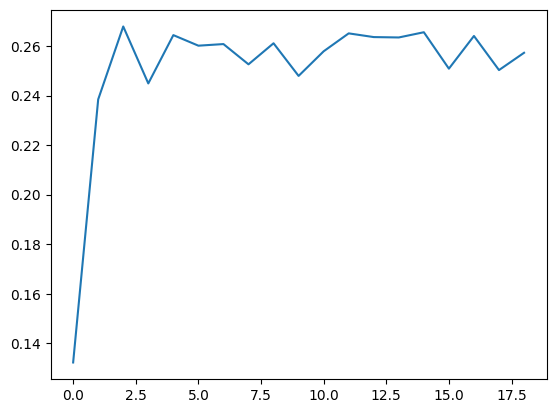

In [21]:
scores = [metrics.adjusted_rand_score(Y_mnist_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.show()